In [ ]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import quaternion
from mpl_toolkits.mplot3d import Axes3D
import math
import pandas as pd
from kalman import *
from scipy.spatial.transform import Rotation


# Orientation estimation using extended kalman filter
  Based on: X. Yun and E. R. Bachmann, ‘Design, Implementation, and Experimental Results of a Quaternion-Based Kalman Filter for Human Body Motion Tracking’, IEEE Trans. Robot., vol. 22, no. 6, pp. 1216–1227, Dec. 2006, doi: 10.1109/TRO.2006.886270.
  
The state vector contains 3D angular velocity and quaternion: 
$$
\vec{x} = \begin{pmatrix} \omega_x & \omega_y & \omega_z & q_1 & q_2 & q_3 & q_4 \end{pmatrix}^T
$$

1. define functions
2. import dataset
3. filter
4. visualise

## define functions

In [12]:
def verify_data_structure(gyr, acc):
    print("Data Structure Information:")
    print(f"Gyroscope data shape: {gyr.shape}")
    print(f"Accelerometer data shape: {acc.shape}")
    print(f"Gyroscope data sample: {gyr[0]}")
    print(f"Accelerometer data sample: {acc[0]}")
    
    # Verify data types
    print(f"\nData Types:")
    print(f"Gyroscope data type: {gyr.dtype}")
    print(f"Accelerometer data type: {acc.dtype}")
    
    # Verify data ranges
    print(f"\nData Ranges:")
    print(f"Gyroscope range: [{np.min(gyr)}, {np.max(gyr)}]")
    print(f"Accelerometer range: [{np.min(acc)}, {np.max(acc)}]")

In [14]:
class QuaternionEKF:
    def __init__(self):
        # state vector: [p, q, r, a, b, c, d]
        # p,q,r are angular rates
        # a,b,c,d are quaternion components
        self.state = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
        
        # state covariance
        self.P = np.eye(7) * 0.1

        # process noise
        self.Q = np.eye(7)
        self.Q[:3, :3] *= 0.25  # angular rates noise
        self.Q[3:, 3:] *= 0.1  # quaternion noise
        
        # measurement noise
        self.R = np.eye(7) * 1000
        
        # system parameters
        self.dt = 0.04  # sample time
        self.tau = 0.2  # Time constant for angular rates
        
    def quaternion_multiply(self, q1, q2):
        """Multiply two quaternions"""
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])
    
    def quaternion_to_rotation_matrix(self, q):
        """
        Convert quaternion to rotation matrix
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        # Extract quaternion components
        q0, q1, q2, q3 = q
        
        # Compute rotation matrix elements
        R = np.array([
            [1 - 2*q2**2 - 2*q3**2,     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
            [    2*(q1*q2 + q0*q3), 1 - 2*q1**2 - 2*q3**2,     2*(q2*q3 - q0*q1)],
            [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*q1**2 - 2*q2**2]
        ])
        
        return R

    def quaternion_multiply(self, q1, q2):
        """
        Multiply two quaternions
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,  # w
            w1*x2 + x1*w2 + y1*z2 - z1*y2,  # x
            w1*y2 - x1*z2 + y1*w2 + z1*x2,  # y
            w1*z2 + x1*y2 - y1*x2 + z1*w2   # z
        ])

    def quaternion_conjugate(self, q):
        """
        Compute quaternion conjugate
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        return np.array([q[0], -q[1], -q[2], -q[3]])

    def rotate_vector(self, v, q):
        """
        Rotate vector v by quaternion q
        """
        # Convert vector to pure quaternion
        v_quat = np.array([0, v[0], v[1], v[2]])
        
        # Compute rotation: q * v * q^*
        q_conj = self.quaternion_conjugate(q)
        rotated = self.quaternion_multiply(
            self.quaternion_multiply(q, v_quat),
            q_conj
        )
        
        # Return vector part
        return rotated[1:]

    def compute_measurement_jacobian(self, q, acc_earth, mag_earth):
        """
        Compute Jacobian matrix for measurement model
        """
        # Initialize Jacobian matrix (6x4 for accelerometer and magnetometer)
        J = np.zeros((6, 4))
        
        # Compute Jacobian for accelerometer measurements
        q0, q1, q2, q3 = q
        
        # Accelerometer Jacobian
        J[0:3, 0] = np.array([
            2*(q0*acc_earth[0] + q3*acc_earth[1] - q2*acc_earth[2]),
            2*(q3*acc_earth[0] + q0*acc_earth[1] + q1*acc_earth[2]),
            2*(-q2*acc_earth[0] + q1*acc_earth[1] + q0*acc_earth[2])
        ])
        
        J[0:3, 1] = np.array([
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2]),
            2*(q2*acc_earth[0] - q1*acc_earth[1] - q0*acc_earth[2]),
            2*(q3*acc_earth[0] - q0*acc_earth[1] - q1*acc_earth[2])
        ])
        
        J[0:3, 2] = np.array([
            2*(-q2*acc_earth[0] + q1*acc_earth[1] + q0*acc_earth[2]),
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2]),
            2*(-q0*acc_earth[0] - q3*acc_earth[1] + q2*acc_earth[2])
        ])
        
        J[0:3, 3] = np.array([
            2*(-q3*acc_earth[0] + q0*acc_earth[1] + q1*acc_earth[2]),
            2*(q0*acc_earth[0] - q3*acc_earth[1] + q2*acc_earth[2]),
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2])
        ])
        
        # Magnetometer Jacobian (similar structure but with mag_earth)
        J[3:6, 0] = np.array([
            2*(q0*mag_earth[0] + q3*mag_earth[1] - q2*mag_earth[2]),
            2*(q3*mag_earth[0] + q0*mag_earth[1] + q1*mag_earth[2]),
            2*(-q2*mag_earth[0] + q1*mag_earth[1] + q0*mag_earth[2])
        ])
        
        J[3:6, 1] = np.array([
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2]),
            2*(q2*mag_earth[0] - q1*mag_earth[1] - q0*mag_earth[2]),
            2*(q3*mag_earth[0] - q0*mag_earth[1] - q1*mag_earth[2])
        ])
        
        J[3:6, 2] = np.array([
            2*(-q2*mag_earth[0] + q1*mag_earth[1] + q0*mag_earth[2]),
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2]),
            2*(-q0*mag_earth[0] - q3*mag_earth[1] + q2*mag_earth[2])
        ])
        
        J[3:6, 3] = np.array([
            2*(-q3*mag_earth[0] + q0*mag_earth[1] + q1*mag_earth[2]),
            2*(q0*mag_earth[0] - q3*mag_earth[1] + q2*mag_earth[2]),
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2])
        ])
        
        return J
    
    def gauss_newton_optimization(self, acc_body, mag_body, acc_earth, mag_earth, initial_quaternion):
        """
        Gauss-Newton optimization for finding optimal quaternion
        """
        q = initial_quaternion.copy()
        max_iterations = 3  # As suggested in the paper
        
        for _ in range(max_iterations):
            # Create rotation matrix from current quaternion
            R = self.quaternion_to_rotation_matrix(q)
            
            # Predict measurements in body frame
            acc_pred = R @ acc_earth
            mag_pred = R @ mag_earth
            
            # Compute error
            error_acc = acc_body - acc_pred
            error_mag = mag_body - mag_pred
            error = np.concatenate([error_acc, error_mag])
            
            # Compute Jacobian
            J = self.compute_measurement_jacobian(q, acc_earth, mag_earth)
            
            # Gauss-Newton update
            try:
                delta = np.linalg.inv(J.T @ J) @ J.T @ error
                q = q + delta
                q = q / np.linalg.norm(q)  # Normalize
            except np.linalg.LinAlgError:
                print("Warning: Singular matrix in Gauss-Newton update")
                break
                
        return q

    def predict(self):
        """Prediction step"""
        # Extract current states
        p, q, r = self.state[:3]
        quat = self.state[3:]
        
        # Angular rate model
        p_dot = -p/self.tau
        q_dot = -q/self.tau
        r_dot = -r/self.tau
        
        # Quaternion rate
        omega = np.array([0, p, q, r])
        quat_dot = 0.5 * self.quaternion_multiply(quat, omega)
        
        # Update state
        self.state[:3] += np.array([p_dot, q_dot, r_dot]) * self.dt
        self.state[3:] += quat_dot * self.dt
        
        # Normalize quaternion
        self.state[3:] /= np.linalg.norm(self.state[3:])
        
        # Compute Jacobian
        F = self.get_state_transition_matrix()
        
        # Update covariance
        self.P = F @ self.P @ F.T + self.Q
        
    def get_state_transition_matrix(self):
        """Compute state transition matrix"""
        F = np.eye(7)
        dt = self.dt
        p, q, r = self.state[:3]
        a, b, c, d = self.state[3:]
        
        # Angular rate terms
        F[:3, :3] = np.eye(3) * (1 - dt/self.tau)
        
        # Quaternion terms
        F[3:, 3:] = np.eye(4) + dt * 0.5 * np.array([
            [0, -p, -q, -r],
            [p, 0, r, -q],
            [q, -r, 0, p],
            [r, q, -p, 0]
        ])
        
        return F
    
    def update(self, measurement):
        """Update step using MARG measurements"""
        # Compute Kalman gain
        H = np.eye(7)  # Measurement matrix is identity
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state
        innovation = measurement - self.state
        self.state += K @ innovation
        
        # Normalize quaternion part
        self.state[3:] /= np.linalg.norm(self.state[3:])
        
        # Update covariance
        self.P = (np.eye(7) - K @ H) @ self.P
    
    def process_measurement(self, gyro, accel, mag, quaternion):
        """Process one set of MARG sensor measurements"""
        # First predict
        self.predict()
                
        # Combine with gyro for measurement update
        measurement = np.zeros(7)
        measurement[:3] = gyro
        measurement[3:] = quaternion
        
        # Update
        self.update(measurement)
        
        return self.state.copy()
    
    def compute_orientation_quaternion(self, accel, mag):
        """Compute orientation quaternion from accelerometer and magnetometer"""
        accel = accel / np.linalg.norm(accel)
        mag = mag / np.linalg.norm(mag)

        acc_earth = np.array([0, 0, -9.81])
        mag_earth = np.array([0.22, 0, -0.44])
        # mag_earth = mag_earth / np.linalg.norm(mag_earth)
        
        self.gauss_newton_optimization(acc, mag, acc_earth, mag_earth, self.state[3:7])
        return R.as_quat()[[3,0,1,2]]  # reorder to [w,x,y,z]




In [32]:
def quaternion_to_euler_angles(q):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw) in radians.
    Quaternion format assumed as [w, x, y, z].
    """
    w, x, y, z = q
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.arcsin(sinp) if abs(sinp) <= 1 else np.pi / 2 * np.sign(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

## import dataset

In [ ]:
df = pd.read_csv('../utils/labeled_data/rotate_x_axis_90deg.csv')
acc = np.array([
    df['Accel_X'], df['Accel_Y'], df['Accel_Z']
]).T
mag = np.array([
    df['Magneto_X'], df['Magneto_Y'], df['Magneto_Z']
]).T
gyr = np.array([
    df['Gyro_X'], df['Gyro_Y'], df['Gyro_Z']
]).T

q = np.array([
    df['Quaternion_W'], df['Quaternion_X'], df['Quaternion_Y'], df['Quaternion_Z'] 
]).T

assert acc.shape[1] == 3, "Wrong accelerometer data shape!"
assert mag.shape[1] == 3, "Wrong magnetometer data shape!"
assert gyr.shape[1] == 3, "Wrong gyroscope data shape!"

n = acc.shape[0]
print(f'We have {n} measurements.')
verify_data_structure(gyr, acc)

We have 173 measurements.
Data Structure Information:
Gyroscope data shape: (173, 3)
Accelerometer data shape: (173, 3)
Gyroscope data sample: [ 0.125  -0.3125  0.    ]
Accelerometer data sample: [ 0.17       -0.25        9.51000023]

Data Types:
Gyroscope data type: float64
Accelerometer data type: float64

Data Ranges:
Gyroscope range: [-46.125, 2.8125]
Accelerometer range: [-1.2000000476837158, 9.75]


## filter

In [17]:
ekf = QuaternionEKF()
n_samples = len(gyr)
predictions = np.zeros((n_samples, 4))

for i in range(n_samples):
    state = ekf.process_measurement(gyr[i], acc[i], mag[i], q[i])
    predictions[i] = state[3:7]

print(f'There are {predictions.shape[0]} predictions.')

There are 173 predictions.


## visualise

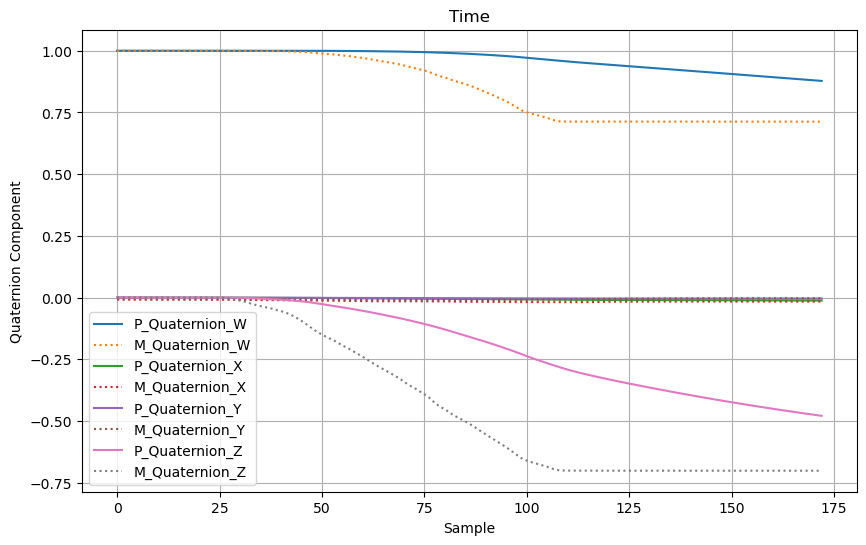

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='P_Quaternion_W')
plt.plot(q[:, 0], label='M_Quaternion_W', linestyle = ':')
plt.plot(predictions[:, 1], label='P_Quaternion_X')
plt.plot(q[:, 1], label='M_Quaternion_X', linestyle = ':')
plt.plot(predictions[:, 2], label='P_Quaternion_Y')
plt.plot(q[:, 2], label='M_Quaternion_Y', linestyle = ':')
plt.plot(predictions[:, 3], label='P_Quaternion_Z')
plt.plot(q[:, 3], label='M_Quaternion_Z', linestyle = ':')
plt.xlabel('Sample')
plt.ylabel('Quaternion Component')
plt.title('Time')
plt.legend()
plt.grid()
plt.show()

In [38]:
print(f'q size: {q.shape}')

predicted_roll= np.zeros((n_samples,1))
predicted_pitch = np.zeros((n_samples,1))
predicted_yaw = np.zeros((n_samples,1))
measured_roll = np.zeros((n_samples,1))
measured_pitch = np.zeros((n_samples,1))
measured_yaw = np.zeros((n_samples,1))

for i in range(n_samples):
    m_roll, m_pitch, m_yaw = quaternion_to_euler_angles(q[i])
    measured_roll[i] = m_roll
    measured_pitch[i] = m_pitch
    measured_yaw[i] = m_yaw
    p_roll, p_pitch, p_yaw = quaternion_to_euler_angles(predictions[i])
    predicted_roll[i] = p_roll
    predicted_pitch[i] = p_pitch
    predicted_yaw[i] = p_yaw

assert measured_roll.shape[0] == n_samples, "Wrong measured_roll data shape"
assert measured_pitch.shape[0] == n_samples, "Wrong measured_pitch data shape"
assert measured_yaw.shape[0] == n_samples, "Wrong measured_yaw data shape"


q size: (173, 4)


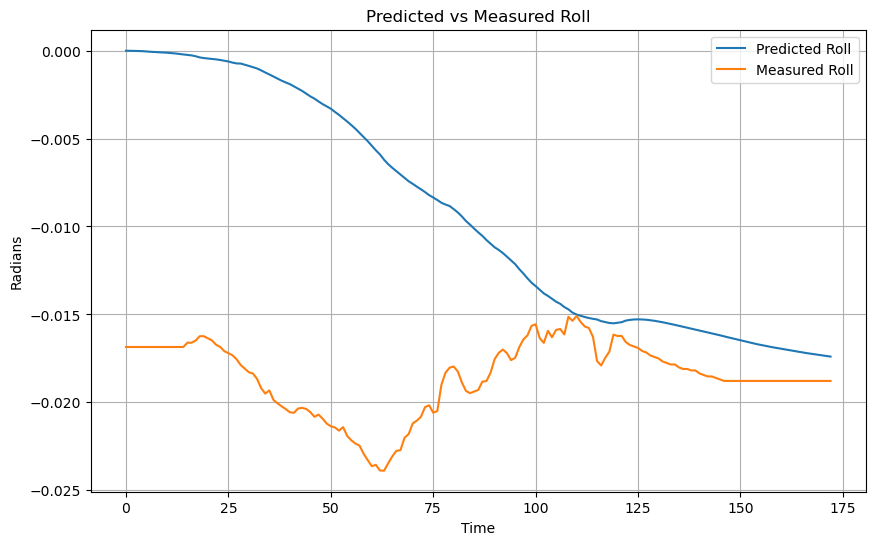

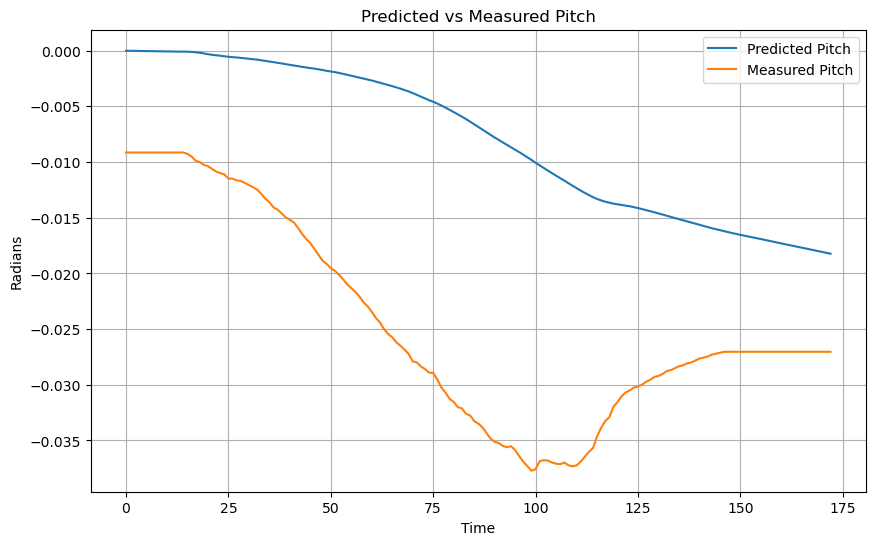

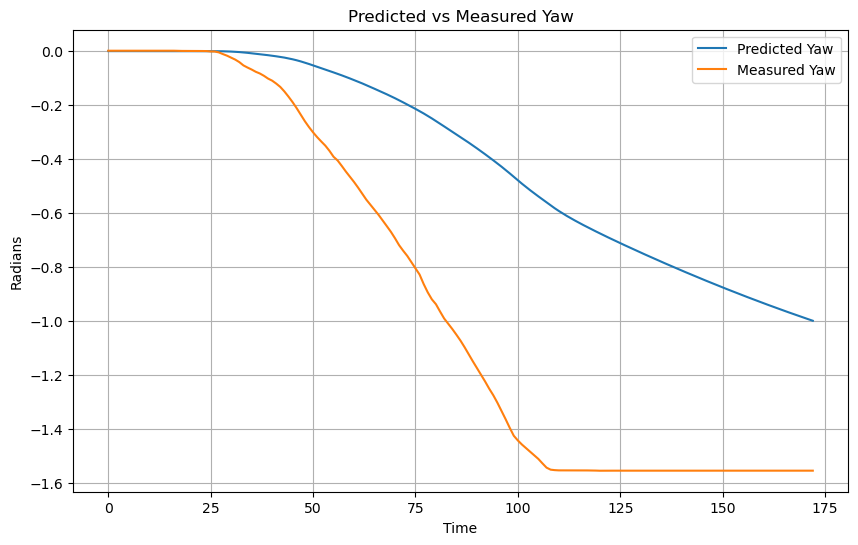

In [40]:

plt.figure(figsize=(10, 6))
plt.plot( predicted_roll, label='Predicted Roll')
plt.plot(measured_roll, label='Measured Roll')
#plt.axhline(y=180*np.pi/180, color='r', label="90 degrees")
plt.xlabel('Time')
plt.ylabel('Radians')
plt.title('Predicted vs Measured Roll')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot( predicted_pitch, label='Predicted Pitch')
plt.plot(measured_pitch, label='Measured Pitch')
#plt.axhline(y=90*np.pi/180, color='r', label="90 degrees")
plt.xlabel('Time')
plt.ylabel('Radians')
plt.title('Predicted vs Measured Pitch')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(predicted_yaw, label='Predicted Yaw')
plt.plot(measured_yaw, label='Measured Yaw')
#plt.axhline(y=-90*np.pi/180, color='r', label="90 degrees")
plt.xlabel('Time')
plt.ylabel('Radians')
plt.title('Predicted vs Measured Yaw')
plt.legend()
plt.grid()
plt.show()
